Test hyperparameter optimization for Logistic regression case

In [22]:
import sys
import torch
import torch.nn as nn
sys.path.append("..")
from hyper_opt import ConjugateHyperOptimizer, NeumannHyperOptimizer, FixedPointHyperOptimizer
from model import BaseHyperOptModel

import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

Create Logistic Regression model and its corresponding hyperparameter-optimization wrapper

In [23]:
class LogisticRegression(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.w = nn.Parameter(torch.randn((input_dim, 1)))
    
    def forward(self, x):
        return x @ self.w
    

class LRHyperOptModel(BaseHyperOptModel):
    
    def __init__(self, input_dim) -> None:
        network = LogisticRegression(input_dim)
        criterion = nn.BCEWithLogitsLoss()
        super().__init__(network, criterion)
        
        self.hparams = nn.Parameter(torch.ones(input_dim,1))
        
    @property
    def hyper_parameters(self):
        return [self.hparams]
    
    def regularizer(self):
        return 0.5 * (self.network.w.t() @ torch.diag(self.hparams.squeeze())) @ self.network.w


Create data

In [24]:
torch.manual_seed(0)
n, d = 1000, 20   # num of data and num of dimension
w_oracle = torch.randn(d, 1)
x = torch.randn(n, d)
y = x @ w_oracle + 0.1*torch.randn(n, 1)
y = (y >0.).float()

x_train, y_train = x[:n//2], y[:n//2]
x_val, y_val = x[n//2:], y[n//2:]

# test_data
n_test = 1000
x_test = torch.randn(n_test, d)
y_test = x_test @ w_oracle + 0.1 * torch.randn(n_test, 1)
y_test = (y_test > 0.).float()


Instantiating model + Optimizers

In [25]:
outer_steps = 500  # num of outer steps 
T, K = 100, 10  # num of inner steps and number of iterations in solvers

model = LRHyperOptModel(input_dim=d)
train_loss,_ = model.train_loss(x_train, y_train)
val_loss = model.validation_loss(x_val, y_val)

w_optimizer = torch.optim.SGD(model.parameters, lr=0.1)

## choose between methods
## First: Conjugate Gradient
# hyper_optimizer = ConjugateHyperOptimizer(model.parameters, model.hyper_parameters, default=dict(lr=1., momentum=.9))
# hyper_optimizer.build_inverse_hvp(num_iter=K)

## Second: Neumann
# hyper_optimizer = NeumannHyperOptimizer(model.parameters, model.hyper_parameters, default=dict(lr=1., momentum=.9), use_gauss_newton=False)
# hyper_optimizer.build_inverse_hvp(lr=1., truncate_iter=K)
# hyper_optimizer = NeumannHyperOptimizer(model.parameters, model.hyper_parameters, default=dict(lr=1., momentum=.9), use_gauss_newton=True)
# hyper_optimizer.build_inverse_hvp(lr=1., truncate_iter=K)

## Third fixed point
hyper_optimizer = FixedPointHyperOptimizer(model.parameters, model.hyper_parameters,default=dict(lr=1., momentum=.9))


Let's train the model

In [26]:
val_losses = []
test_losses = []
for o_step in range(outer_steps):
    
    # inner optimizer
    for t in range(T):
        w_optimizer.zero_grad()
        loss, _ = model.train_loss(x_train, y_train)
        loss.backward()
        w_optimizer.step()
    
    # outer optimizer
    train_loss, train_logit = model.train_loss(x_train, y_train)
    val_loss = model.validation_loss(x_val, y_val)
    hyper_optimizer.step(train_loss, val_loss, train_logit)
    model.hyper_parameters[0].data.clamp_(min=1e-8)
    
    if o_step % 10 == 0:
        print(f"Outer step {o_step:3d} \t Val Loss: {val_loss.item():.3f}")
        test_loss = model.validation_loss(x_test, y_test)
        test_losses.append(test_loss.item())

    val_losses.append(val_loss.item())
    
    

Outer step   0 	 Val Loss: 0.583
Outer step  10 	 Val Loss: 0.531
Outer step  20 	 Val Loss: 0.285
Outer step  30 	 Val Loss: 0.200
Outer step  40 	 Val Loss: 0.160
Outer step  50 	 Val Loss: 0.131
Outer step  60 	 Val Loss: 0.131
Outer step  70 	 Val Loss: 0.126
Outer step  80 	 Val Loss: 0.115
Outer step  90 	 Val Loss: 0.116
Outer step 100 	 Val Loss: 0.106
Outer step 110 	 Val Loss: 0.109
Outer step 120 	 Val Loss: 0.104
Outer step 130 	 Val Loss: 0.106
Outer step 140 	 Val Loss: 0.103
Outer step 150 	 Val Loss: 0.108
Outer step 160 	 Val Loss: 0.103
Outer step 170 	 Val Loss: 0.105
Outer step 180 	 Val Loss: 0.101
Outer step 190 	 Val Loss: 0.100
Outer step 200 	 Val Loss: 0.095
Outer step 210 	 Val Loss: 0.095
Outer step 220 	 Val Loss: 0.098
Outer step 230 	 Val Loss: 0.095
Outer step 240 	 Val Loss: 0.095
Outer step 250 	 Val Loss: 0.094
Outer step 260 	 Val Loss: 0.099
Outer step 270 	 Val Loss: 0.095
Outer step 280 	 Val Loss: 0.097
Outer step 290 	 Val Loss: 0.094
Outer step

Current implemetation CG return NaN at a large outer steps but it still converges. Neumann produces some ocsilations (which is not good)

Text(0.5, 0, 'outer steps')

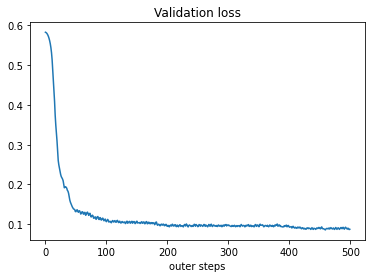

In [27]:
plt.plot(val_losses)
plt.title("Validation loss")
plt.xlabel("outer steps")


Text(0.5, 1.0, 'Test loss')

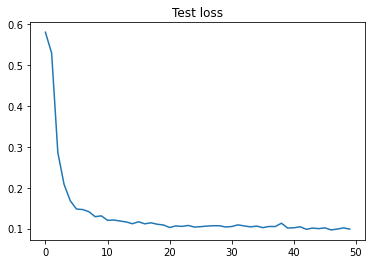

In [28]:
plt.plot(test_losses)
plt.title("Test loss")